<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [1]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [3]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [4]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



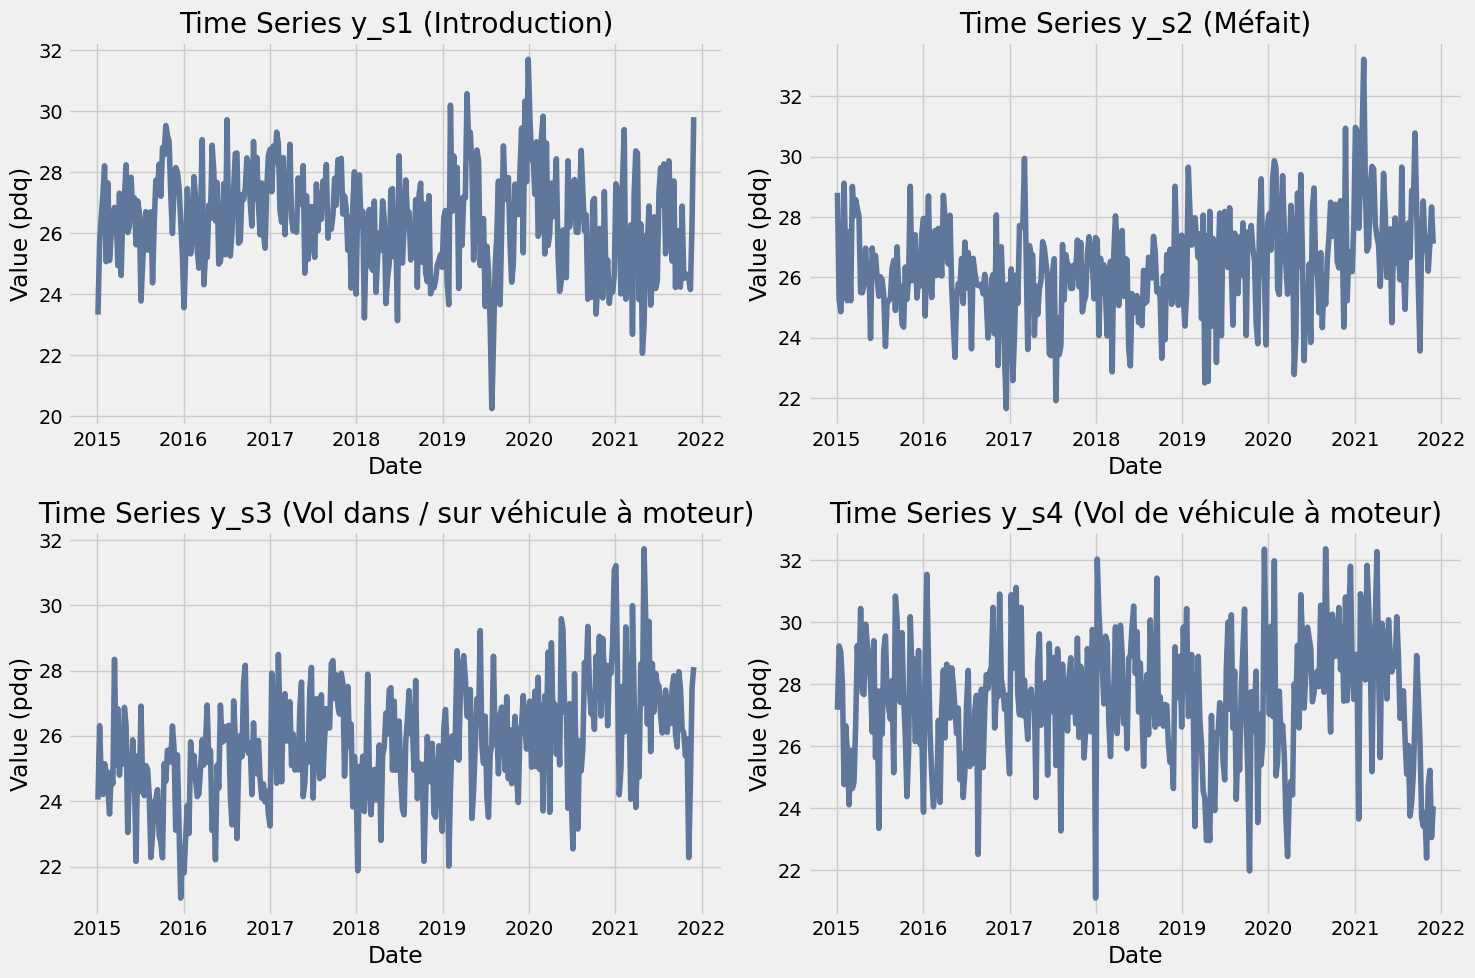

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

series_list = [y_s1, y_s2, y_s3, y_s4]
titles = ['Time Series y_s1 (Introduction)', 'Time Series y_s2 (Méfait)', 'Time Series y_s3 (Vol dans / sur véhicule à moteur)', 'Time Series y_s4 (Vol de véhicule à moteur)']

for i, series in enumerate(series_list):
    axes[i].plot(series['pdq'])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Value (pdq)')
    axes[i].grid(True)

plt.tight_layout()
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [6]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

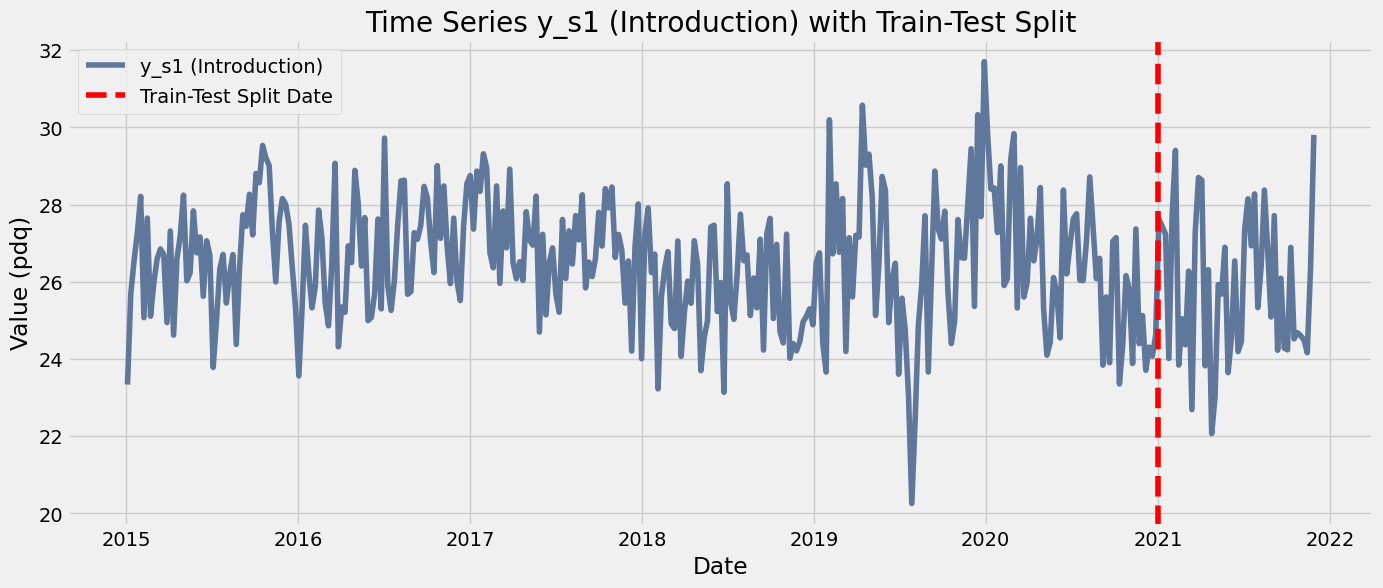

In [7]:

y_selected = y_s1.copy()

plt.figure(figsize=(15, 6))
plt.plot(y_selected['pdq'], label='y_s1 (Introduction)')
plt.axvline(x=pd.to_datetime(target_date), color='r', linestyle='--', label='Train-Test Split Date')
plt.title('Time Series y_s1 (Introduction) with Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Value (pdq)')
plt.legend()
plt.grid(True)
plt.show()




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [19]:
from prophet import Prophet
# ==== SARIMA: búsqueda y evaluación ====
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fallbacks por si no existen aún:
if 'y_selected' not in globals():
    y_selected = y_s1.copy()
if 'target_date' not in globals():
    target_date = '2021-01-01'
if 'params' not in globals():
    import itertools
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]
    params = list(itertools.product(pdq, seasonal_pdq))

def _train_test_split_ts(y_df, split_date):
    """Divide la serie con índice datetime y col 'pdq' en train/test según split_date."""
    split_date = pd.to_datetime(split_date)
    mask = y_df.index < split_date
    y_train = y_df.loc[mask, 'pdq']
    y_test  = y_df.loc[~mask, 'pdq']
    return y_train, y_test

def evaluate_sarima_grid(y_df, split_date, param_grid):
    """Entrena SARIMA para cada (order, seasonal_order) y devuelve DataFrame con métricas."""
    y_train, y_test = _train_test_split_ts(y_df, split_date)
    rows = []

    # Suaviza warnings de convergencia para no ensuciar la salida
    warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)

    for (order, seasonal_order) in param_grid:
        try:
            model = SARIMAX(
                y_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = model.fit(disp=0)

            preds = res.get_prediction(
                start=y_test.index.min(),
                end=y_test.index.max(),
                dynamic=False
            ).predicted_mean

            df_tmp = pd.DataFrame({'y': y_test.values, 'yhat': preds.values}, index=y_test.index)
            m = summary_metrics(df_tmp)

            m['model'] = f"SARIMA{order}x{seasonal_order}"
            m['order'] = [order]
            m['seasonal_order'] = [seasonal_order]
            rows.append(m)

        except Exception as e:
            continue

    warnings.filterwarnings("default", category=sm.tools.sm_exceptions.ConvergenceWarning)

    if not rows:
        raise RuntimeError("No se pudo ajustar ningún modelo SARIMA con las combinaciones dadas.")

    out = pd.concat(rows, ignore_index=True).sort_values('rmse').reset_index(drop=True)
    return out

df_sarima_results = evaluate_sarima_grid(y_selected, target_date, params)

print("Top-10 modelos por RMSE (menor es mejor):")
display(df_sarima_results.head(10))


Top-10 modelos por RMSE (menor es mejor):


,mae,mse,rmse,mape,maape,wmape,mmape,smape,model,order,seasonal_order
0,1.5876,3.4224,1.8500,0.0622,0.0620,0.0614,0.0599,0.0614,"SARIMA(0, 0, 0)x(1, 0, 1, 12)","(0, 0, 0)","(1, 0, 1, 12)"
1,1.5934,3.4304,1.8521,0.0624,0.0622,0.0616,0.0600,0.0616,"SARIMA(0, 0, 1)x(1, 0, 1, 12)","(0, 0, 1)","(1, 0, 1, 12)"
2,1.6021,3.4537,1.8584,0.0627,0.0625,0.0619,0.0603,0.0619,"SARIMA(1, 0, 0)x(1, 0, 1, 12)","(1, 0, 0)","(1, 0, 1, 12)"
3,1.6444,3.7833,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA(0, 0, 0)x(1, 1, 1, 12)","(0, 0, 0)","(1, 1, 1, 12)"
4,1.6444,3.7832,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA(0, 0, 0)x(0, 1, 1, 12)","(0, 0, 0)","(0, 1, 1, 12)"
5,1.6576,3.8281,1.9566,0.0659,0.0657,0.0641,0.0634,0.0640,"SARIMA(0, 0, 1)x(0, 1, 1, 12)","(0, 0, 1)","(0, 1, 1, 12)"
6,1.6576,3.8281,1.9566,0.0659,0.0657,0.0641,0.0634,0.0640,"SARIMA(0, 0, 1)x(1, 1, 1, 12)","(0, 0, 1)","(1, 1, 1, 12)"
7,1.6704,3.8611,1.9650,0.0664,0.0661,0.0646,0.0638,0.0645,"SARIMA(1, 0, 0)x(0, 1, 1, 12)","(1, 0, 0)","(0, 1, 1, 12)"
8,1.6704,3.8611,1.9650,0.0664,0.0661,0.0646,0.0638,0.0645,"SARIMA(1, 0, 0)x(1, 1, 1, 12)","(1, 0, 0)","(1, 1, 1, 12)"
9,1.6905,3.8859,1.9713,0.0667,0.0664,0.0653,0.0641,0.0653,"SARIMA(1, 0, 1)x(0, 1, 1, 12)","(1, 0, 1)","(0, 1, 1, 12)"


Mejor modelo: SARIMA(0, 0, 0)x(1, 0, 1, 12)
mae     1.5876
mse     3.4224
rmse      1.85
Name: 0, dtype: object


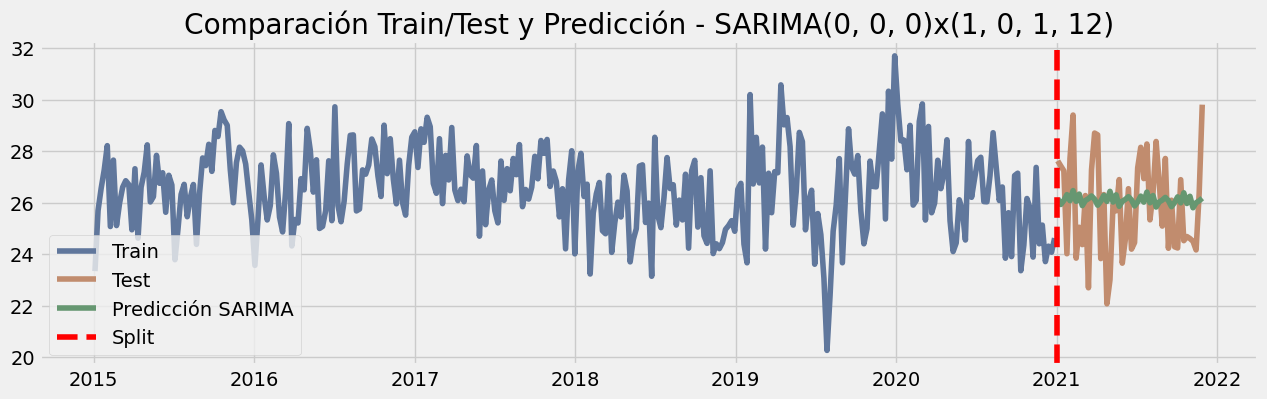

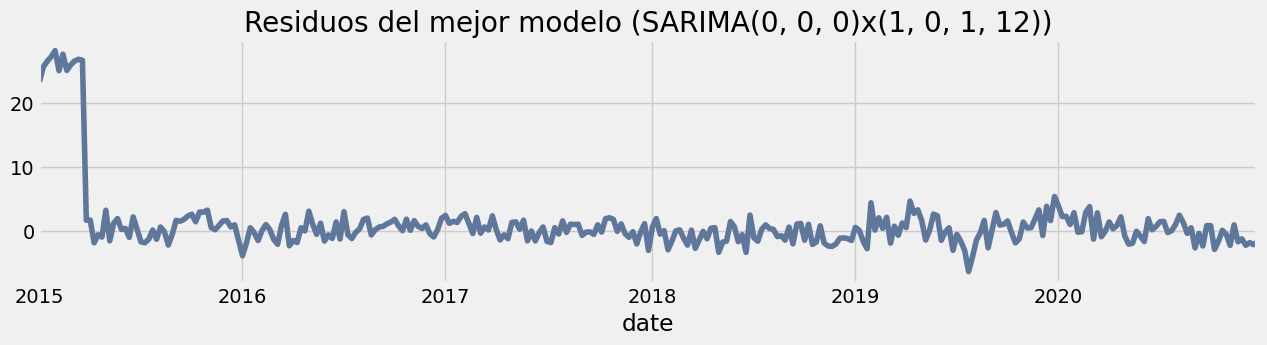

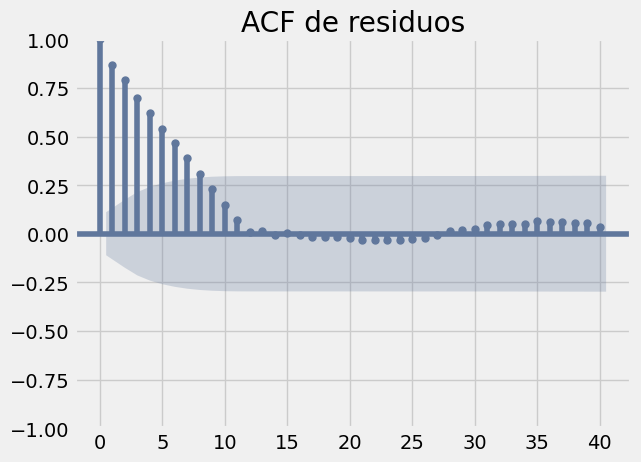

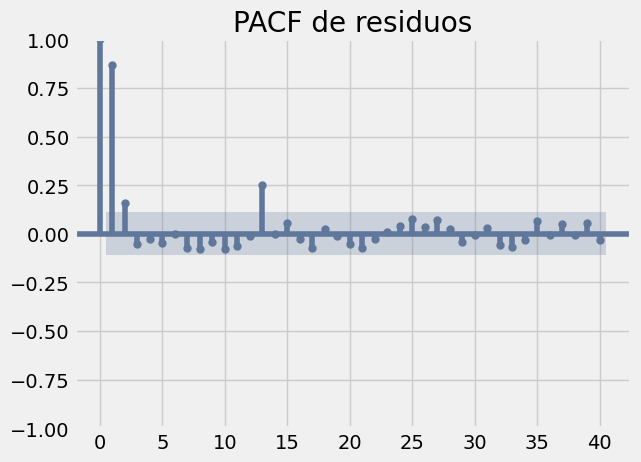

Ljung-Box p-values:
         lb_pvalue
10  2.360699e-204
20  1.535391e-195
Conclusión: se detecta autocorrelación en residuos -> revisar especificación del modelo.


In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Seleccionar el mejor por RMSE:
best_row = df_sarima_results.iloc[0]
best_order = tuple(best_row['order'])
best_seasonal = tuple(best_row['seasonal_order'])
print("Mejor modelo:", best_row['model'])
print(best_row[['mae','mse','rmse']])

# Reentrenar en TRAIN y evaluar contra TEST:
y_train, y_test = _train_test_split_ts(y_selected, target_date)
best_model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=0)

pred = best_model.get_prediction(start=y_test.index.min(), end=y_test.index.max())
pred_mean = pred.predicted_mean

# Gráfico Train/Test vs Predicción
plt.figure(figsize=(14,4))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(pred_mean.index, pred_mean, label='Predicción SARIMA')
plt.axvline(pd.to_datetime(target_date), ls='--', c='r', label='Split')
plt.title(f"Comparación Train/Test y Predicción - {best_row['model']}")
plt.legend()
plt.grid(True)
plt.show()

# Diagnóstico de residuos: ¿ruido blanco?
residuals = best_model.resid.dropna()

fig = residuals.plot(title=f"Residuos del mejor modelo ({best_row['model']})", figsize=(14,3))
plt.grid(True); plt.show()

sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title("ACF de residuos"); plt.show()

sm.graphics.tsa.plot_pacf(residuals, lags=40, method='ywm')
plt.title("PACF de residuos"); plt.show()

# Prueba de Ljung-Box (p-valor alto -> no hay autocorrelación => ruido blanco)
lb = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
print("Ljung-Box p-values:\n", lb[['lb_pvalue']])
if (lb['lb_pvalue'] > 0.05).all():
    print("Conclusión: no se rechaza H0 de no autocorrelación -> residuos ~ ruido blanco.")
else:
    print("Conclusión: se detecta autocorrelación en residuos -> revisar especificación del modelo.")


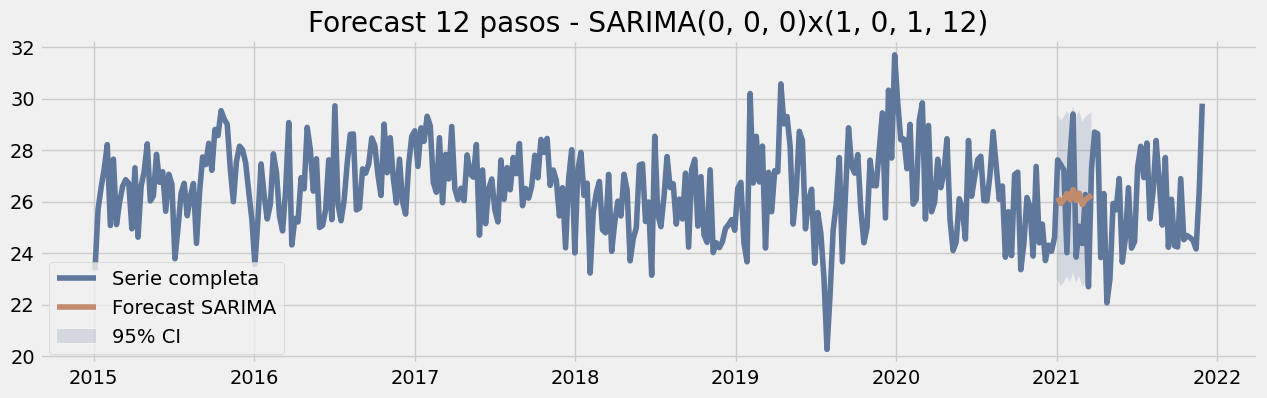

In [21]:
# Pronosticar k pasos más allá del último dato:
k = 12  # semanas a futuro (ajusta a gusto)
fcast = best_model.get_forecast(steps=k)
fcast_mean = fcast.predicted_mean
fcast_ci = fcast.conf_int()

plt.figure(figsize=(14,4))
plt.plot(y_selected.index, y_selected['pdq'], label='Serie completa')
plt.plot(fcast_mean.index, fcast_mean, label='Forecast SARIMA')
plt.fill_between(fcast_ci.index, fcast_ci.iloc[:,0], fcast_ci.iloc[:,1], alpha=0.2, label='95% CI')
plt.title(f"Forecast {k} pasos - {best_row['model']}")
plt.legend(); plt.grid(True); plt.show()


Conclusion:

* **Mejor modelo (por RMSE):** `SARIMA(0,0,0)×(1,0,1)[12]` con **MAE ≈ 1.59**, **RMSE ≈ 1.85** (MAPE ≈ **6.2%**).
* **Lectura:** el modelo captura la **estacionalidad anual** pero su predicción en test es casi plana (cerca de la media), indicando **baja dinámica de corto plazo**.
* **Diagnóstico de residuos:** **no** son ruido blanco. ACF muestra autocorrelación persistente; PACF con picos en lags 1–2; **Ljung-Box** a 10 y 20 rezagos arroja p-values **≈ 0** (se rechaza H₀).
* **Conclusión:** aunque el error medio es razonable, el modelo está **subespecificado** y no es estadísticamente adecuado. **Recomendación:** incorporar términos no estacionales y/o diferenciación, p.ej. probar `SARIMA(1,0,0)×(1,0,1)[12]`, `SARIMA(0,0,1)×(1,0,1)[12]`, `SARIMA(1,0,1)×(1,0,1)[12]` o variantes con **D=1**, y elegir el que logre **residuos sin autocorrelación**. El **forecast 12 pasos** resultante es casi constante, por lo que su **utilidad predictiva es limitada** hasta corregir la especificación.
